In [60]:
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# SQL toolkit and Object Relational Mapper
from sqlalchemy import create_engine, func, desc, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

# Import datetime functions
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [61]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [62]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [63]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [64]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [65]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [66]:
# Create an inspector for the engine
inspector = inspect(engine)

In [67]:
# Get the columns of the station table
columns_station = [col['name'] for col in inspector.get_columns('station')]
print(columns_station)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [68]:
# Get the columns of the measurement table
columns_measurement = [col['name'] for col in inspector.get_columns('measurement')]
print(columns_measurement)

['id', 'station', 'date', 'prcp', 'tobs']


In [69]:
# Find the most recent date in the measurement table
measurement_most_recent_date = session.query(measurement).order_by(desc(measurement.date)).first().date

# Display the most recent date
print(measurement_most_recent_date)

2017-08-23


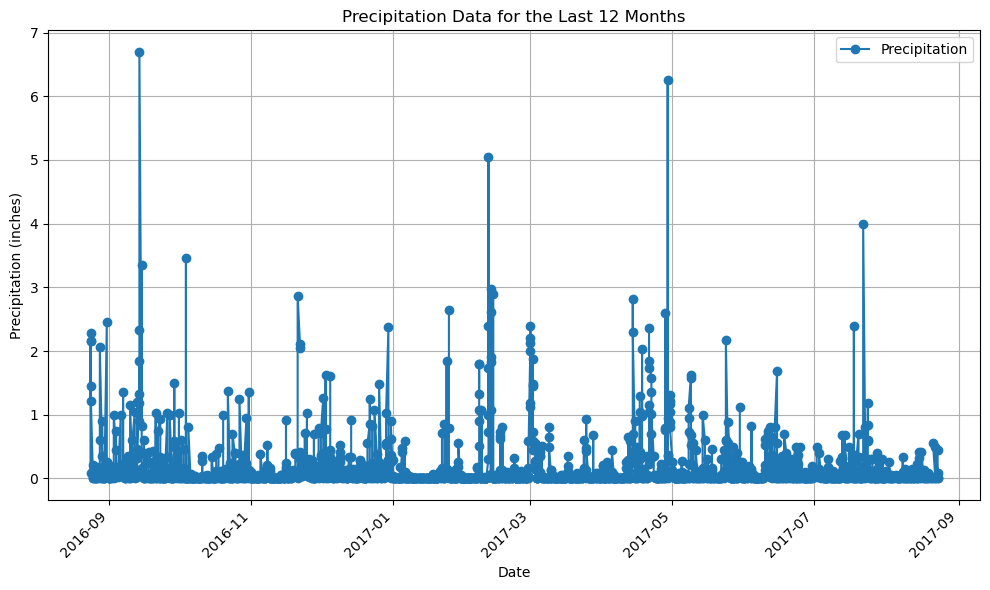

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in the dataset.
twelve_months_ago = datetime.strptime(measurement_most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores.
precipitation_data_12mo = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= twelve_months_ago)\
    .order_by(measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
precipitation_df = pd.DataFrame(precipitation_data_12mo, columns=['Date', 'Precipitation'])

# Ensure the 'Date' column is in datetime format
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Sort the DataFrame by date.
precipitation_df.sort_values(by='Date', ascending=True, inplace=True)
precipitation_df.reset_index(drop=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', kind='line', figsize=(10, 6), marker='o')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.grid(True) 
plt.tight_layout()
plt.show()

In [71]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).distinct().count()
print(total_stations)

9


In [73]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(station.station, station.name, func.count(measurement.id))
    .join(measurement, station.station == measurement.station)  # Use join to relate the tables
    .group_by(station.station, station.name)  # Group by both station.station and station.name
    .order_by(func.count(measurement.id).desc())  # Order by count in descending order
    .all()
)

# Output the results
for station_id, station_name, count in active_stations:
    print(f"Station: {station_id} ({station_name}): Measurement Row Count = {count}")

Station: USC00519281 (WAIHEE 837.5, HI US): Measurement Row Count = 2772
Station: USC00519397 (WAIKIKI 717.2, HI US): Measurement Row Count = 2724
Station: USC00513117 (KANEOHE 838.1, HI US): Measurement Row Count = 2709
Station: USC00519523 (WAIMANALO EXPERIMENTAL FARM, HI US): Measurement Row Count = 2669
Station: USC00516128 (MANOA LYON ARBO 785.2, HI US): Measurement Row Count = 2612
Station: USC00514830 (KUALOA RANCH HEADQUARTERS 886.9, HI US): Measurement Row Count = 2202
Station: USC00511918 (HONOLULU OBSERVATORY 702.2, HI US): Measurement Row Count = 1979
Station: USC00517948 (PEARL CITY, HI US): Measurement Row Count = 1372
Station: USC00518838 (UPPER WAHIAWA 874.3, HI US): Measurement Row Count = 511


In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0].station
most_active_station_name = active_stations[0].name

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).one()  # Use .one() to fetch a single result

# List unpack
temp_min, temp_max, temp_avg = temperature_stats

# Print the results
print(f"Most Active Station: {most_active_station_id} ({most_active_station_name})")
print(f"Lowest Temperature: {temp_min}")
print(f"Highest Temperature: {temp_max}")
print(f"Average Temperature: {round(temp_avg, 2)}")


Most Active Station: USC00519281 (WAIHEE 837.5, HI US)
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


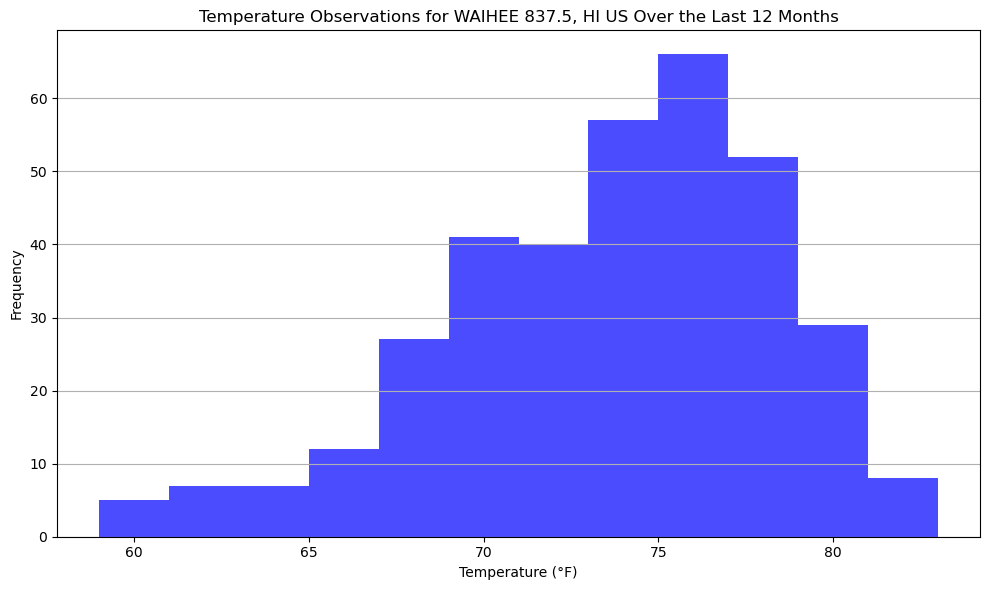

In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temp_data_12mo = session.query(measurement.date, measurement.tobs) \
    .filter(measurement.date >= twelve_months_ago) \
    .filter(measurement.station == most_active_station_id) \
    .order_by(measurement.date) \
    .all()

# Convert the query results into a DataFrame
temp_df = pd.DataFrame(temp_data_12mo, columns=['Date', 'Temperature'])

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_df['Temperature'], bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for {most_active_station_name} Over the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Close Session

In [76]:
# Close Session
session.close()